In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

#### Check the data

In [3]:
features = pd.read_csv('temps.csv')

features.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


In [4]:
print('dataset shape:', features.shape )

dataset shape: (348, 9)


In [5]:
import datetime

days = features['day']
months = features['month']
years = features['year']

dates = [datetime.datetime(year=years[i], month=months[i], day=days[i]) for i in range(len(days))]



In [6]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

#### Plot the data

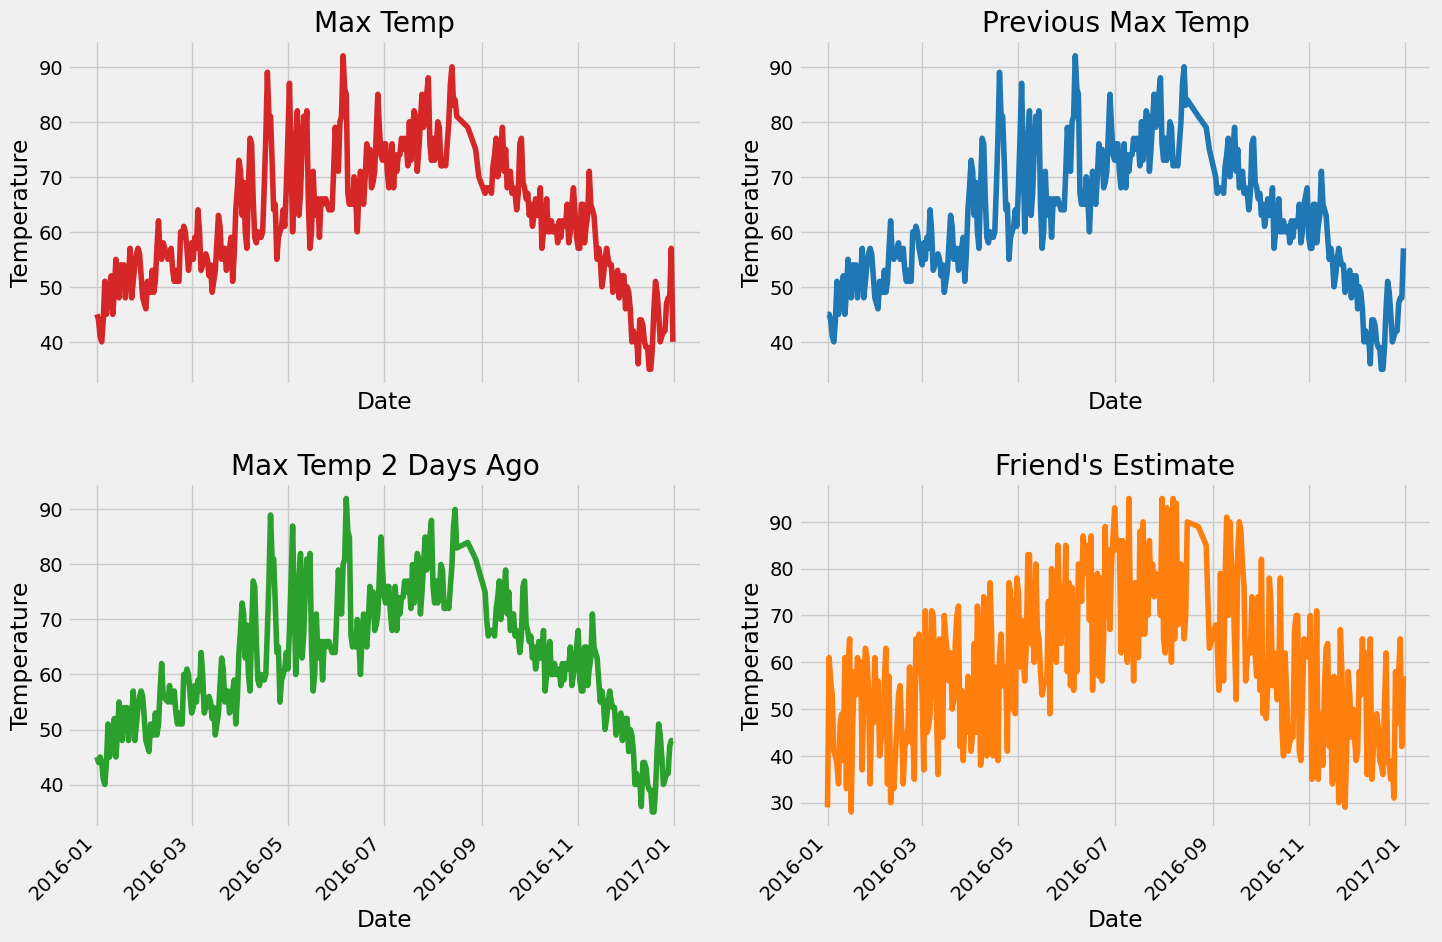

In [10]:
plt.style.use('fivethirtyeight')

# Create figure and axes layout
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.autofmt_xdate(rotation=45)

# Plotting each feature
ax1.plot(dates, features['actual'], color='tab:red')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature')
ax1.set_title('Max Temp')

ax2.plot(dates, features['temp_1'], color='tab:blue')
ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature')
ax2.set_title('Previous Max Temp')

ax3.plot(dates, features['temp_2'], color='tab:green')
ax3.set_xlabel('Date')
ax3.set_ylabel('Temperature')
ax3.set_title('Max Temp 2 Days Ago')

ax4.plot(dates, features['friend'], color='tab:orange')
ax4.set_xlabel('Date')
ax4.set_ylabel('Temperature')
ax4.set_title("Friend's Estimate")

plt.tight_layout(pad=2.0)

In [11]:
features = pd.get_dummies(features)
features.head()

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,True,False,False,False,False,False,False
1,2016,1,2,44,45,45.7,44,61,False,False,True,False,False,False,False
2,2016,1,3,45,44,45.8,41,56,False,False,False,True,False,False,False
3,2016,1,4,44,41,45.9,40,53,False,True,False,False,False,False,False
4,2016,1,5,41,40,46.0,44,41,False,False,False,False,False,True,False


In [12]:
# Separate the target label 'actual' from the features
labels = np.array(features['actual'])

# Remove the label column from the features
features= features.drop('actual', axis = 1)

# Save feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [13]:
features.shape

(348, 14)

In [14]:
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)

In [15]:
input_features[0]

array([ 0.        , -1.5678393 , -1.65682171, -1.48452388, -1.49443549,
       -1.3470703 , -1.98891668,  2.44131112, -0.40482045, -0.40961596,
       -0.40482045, -0.40482045, -0.41913682, -0.40482045])

### construct architecture

In [18]:
x = torch.tensor(input_features, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.float32)

weights = torch.randn((14,128), dtype=torch.float32, requires_grad=True)
bias = torch.randn(128, dtype=torch.float32, requires_grad=True)
weights2 = torch.randn((128,1), dtype=torch.float32, requires_grad=True)
bias2 = torch.randn(1, dtype=torch.float32, requires_grad=True)

learning_rate = 0.001
losses = []

for epoch in range(1000):

    # Forward pass
    layer1 = torch.relu(x.mm(weights) + bias)
    y_pred = layer1.mm(weights2) + bias2

    # Compute the loss
    loss = torch.mean((y_pred - y) ** 2)
    losses.append(loss.data.numpy())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Backward pass
    loss.backward()

    weights.data.add_(-learning_rate * weights.grad.data)
    bias.data.add_(-learning_rate * bias.grad.data)
    weights2.data.add_(-learning_rate * weights2.grad.data)
    bias2.data.add_(-learning_rate * bias2.grad.data)

    # Zero the gradients after updating
    weights.grad.data.zero_()
    bias.grad.data.zero_()
    weights2.grad.data.zero_()
    bias2.grad.data.zero_()


    


Epoch 0, Loss: 4814.841796875
Epoch 100, Loss: 159.46810913085938
Epoch 200, Loss: 150.17562866210938
Epoch 300, Loss: 146.60995483398438
Epoch 400, Loss: 144.65061950683594
Epoch 500, Loss: 143.3988037109375
Epoch 600, Loss: 142.5302276611328
Epoch 700, Loss: 141.92669677734375
Epoch 800, Loss: 141.4649658203125
Epoch 900, Loss: 141.10557556152344


In [19]:
y_pred.shape

torch.Size([348, 1])

### simple code to construct the architecture

In [58]:
import torch.nn as nn
import torch.optim as optim

input_size = x.shape[1]
hidden  = 128
output_size = 1
batch_size = 32

my_nn = nn.Sequential(
    nn.Linear(input_size, hidden),
    nn.Dropout(0.4),
    nn.Sigmoid(),
    nn.Linear(hidden, output_size),
)

criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(my_nn.parameters(), lr=0.001)

In [59]:
losses = []
for epoch in range(1000):
    batch_loss = []

    for i in range(0, len(x), batch_size):
        x_batch = x[i:i+batch_size]
        y_batch = y[i:i+batch_size].view(-1,1)
        y_pred = my_nn(x_batch)

        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        batch_loss.append(loss.data.numpy())

    if epoch % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(f'Epoch {epoch}, Loss: {np.mean(batch_loss)}')

Epoch 0, Loss: 3984.869384765625
Epoch 100, Loss: 56.82096862792969
Epoch 200, Loss: 28.888511657714844
Epoch 300, Loss: 24.935762405395508
Epoch 400, Loss: 24.77106285095215
Epoch 500, Loss: 21.06745147705078
Epoch 600, Loss: 21.645414352416992
Epoch 700, Loss: 20.06605339050293
Epoch 800, Loss: 18.650766372680664
Epoch 900, Loss: 19.83619499206543


### forecasting future values

In [60]:
x = torch.tensor(input_features, dtype=torch.float32)
y_pred = my_nn(x).data.numpy()

In [61]:
dates = [str(int(year))+'-'+str(int(month))+'-'+str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

true_data = pd.DataFrame(data={'date': dates, 'actual': labels})

months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

test_dates = [str(int(year))+'-'+str(int(month))+'-'+str(int(day)) for year, month, day in zip(years, months, days)]
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

pred_data = pd.DataFrame(data={'date': test_dates, 'predicted': y_pred.flatten()})

Text(0.5, 1.0, 'Actual vs Predicted Temperatures')

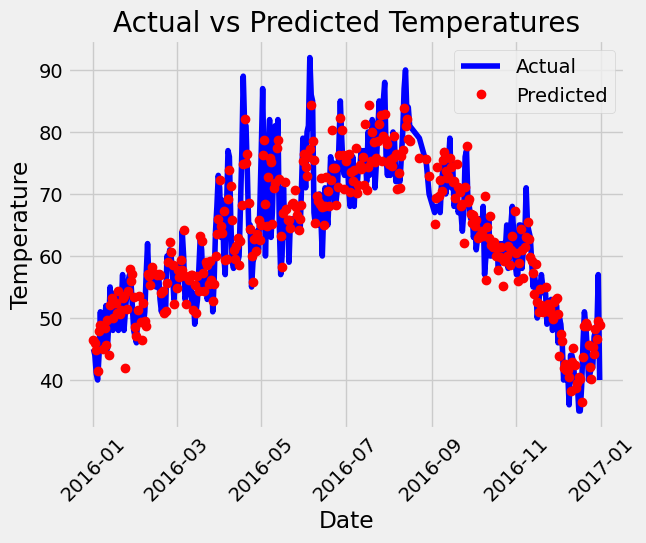

In [62]:
plt.plot(true_data['date'],true_data['actual'],'b-' ,label='Actual')

plt.plot(pred_data['date'], pred_data['predicted'], 'ro', label='Predicted')
plt.xticks(rotation=45)
plt.legend()

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperatures')